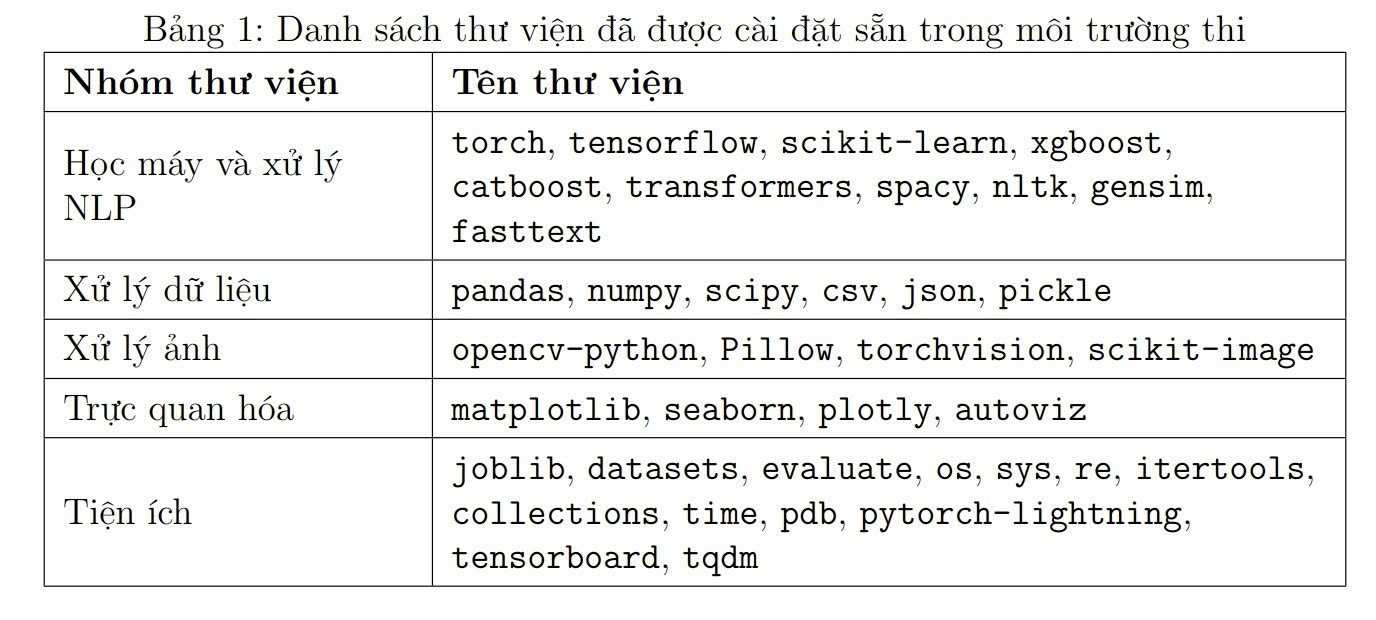

In [1]:
import random, re
from collections import Counter
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

STOP_EN = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("train_news.csv")

In [4]:
len(df['text'][3].split())

314

In [5]:
def clean_text(text: str)->str:
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+|w+','',text)
    text = re.sub(r'\s+',' ',text)

    return text

In [6]:
df['text'] = df['text'].astype(str)

In [7]:
df['text']= df['text'].apply(lambda x: clean_text(x))

In [8]:
df.head()

,text,category
0,Campbell rescues Arsenal Sol Campbell proved t...,sport
1,Algeria hit by further gas riots Algeria suffe...,business
2,Senior Fannie Mae bosses resign The to most se...,business
3,Russia gets investment blessing Soaring oil sa...,business
4,Injury sidelines Philippoussis Mark Philippous...,sport


In [9]:
df['category'].value_counts()

category
business         290
sport            284
tech             221
entertainment    205
Name: count, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
labels = to_categorical(df['label'])

2025-10-28 20:53:11.058964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 20:53:11.070187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761659591.082036  449527 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761659591.085234  449527 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761659591.094790  449527 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [11]:
df.head()

,text,category,label
0,Campbell rescues Arsenal Sol Campbell proved t...,sport,2
1,Algeria hit by further gas riots Algeria suffe...,business,0
2,Senior Fannie Mae bosses resign The to most se...,business,0
3,Russia gets investment blessing Soaring oil sa...,business,0
4,Injury sidelines Philippoussis Mark Philippous...,sport,2


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_NUM_WORDS=10000
MAX_SEQUENCE_LENGTH=256
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=128,
              input_length=MAX_SEQUENCE_LENGTH,
              mask_zero=True),
    SpatialDropout1D(0.2),
    LSTM(
        96,
        return_sequences=False,
        dropout=0.3,                 # dropout trên inputs/outputs của LSTM
        recurrent_dropout=0.3,       # dropout trên trạng thái lặp
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(labels.shape[1], activation='softmax')
])


/home/jupyter2/.conda/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1761659592.722767  449527 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1108 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


In [15]:
optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)  # clipnorm giúp ổn định gradient
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=25,
    batch_size=64,
    callbacks=[early_stop,reduce_lr],
    shuffle=True,
    verbose=1
)

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.2658 - loss: 1.4208 - val_accuracy: 0.3333 - val_loss: 1.4110 - learning_rate: 0.0010
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - accuracy: 0.3316 - loss: 1.4032 - val_accuracy: 0.3667 - val_loss: 1.3979 - learning_rate: 0.0010
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.3756 - loss: 1.3785 - val_accuracy: 0.3917 - val_loss: 1.3664 - learning_rate: 0.0010
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.4524 - loss: 1.2829 - val_accuracy: 0.5333 - val_loss: 1.0676 - learning_rate: 0.0010
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - accuracy: 0.5810 - loss: 1.1587 - val_accuracy: 0.6167 - val_loss: 1.1345 - learning_rate: 0.0010
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.6079 - loss: 1.0555 - val_accuracy: 0.7250 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.7472 - loss: 0.8434 - 

In [18]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8667 - loss: 0.3509
Test Loss: 0.4130
Test Accuracy: 0.8400


In [19]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Dự đoán nhãn
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Nếu y_test là one-hot

# In 4 chỉ số chính
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1-score (weighted): {f1:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Test Loss: 0.4130
Test Accuracy: 0.8400
Test Precision (weighted): 0.8558
Test Recall (weighted): 0.8400
Test F1-score (weighted): 0.8418


In [21]:
test_input="""
The company reported $3.4 billion in revenue, marking a 22% increase year-over-year, while net profit rose to $620 million, up from $460 million in the same period last year. Executives attributed the growth to rapid adoption of Orion’s enterprise AI platform, OrionIQ, across finance, logistics, and manufacturing sectors.
"""
text = clean_text(test_input)

In [22]:
seq = tokenizer.texts_to_sequences([text])
pad = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
pred = model.predict(pad, verbose=0)

In [24]:
label_idx = int(np.argmax(pred, axis=1)[0])
print(label_encoder.classes_[label_idx])

business
